# CODEATHON 3: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 5 bonus points. Part of the total grade (10 pts) is for contributing 100+ images to the dataset, and the 5 bonus pts are for contributing 200+ images to the dataset.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_3.ipynb

Thank you for collecting part of the dataset, best of luck, and have fun! 

# Load Packages

In [0]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, InputLayer, BatchNormalization
from PIL import Image

np.random.seed(49)
tf.random.set_seed(49)

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Import Dataset
The full dataset is huge (+37GB) with +13K images. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been extracted to Dropbox to containly only 5 classes and 10 images each. 

Later, we will share a lite version of the data via another dropbox URL. This dataset will contain all 18 classes, and 100 images each. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [0]:
# Download dataset from AWS
!wget https://uvalandmark20.s3.amazonaws.com/dataset_split.zip

--2020-04-08 03:58:56--  https://uvalandmark20.s3.amazonaws.com/dataset_split.zip
Resolving uvalandmark20.s3.amazonaws.com (uvalandmark20.s3.amazonaws.com)... 52.217.42.148
Connecting to uvalandmark20.s3.amazonaws.com (uvalandmark20.s3.amazonaws.com)|52.217.42.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397586818 (379M) [application/zip]
Saving to: ‘dataset_split.zip’

dataset_split.zip   100%[===================>] 379.17M  72.1MB/s    in 4.9s    

2020-04-08 03:59:02 (77.2 MB/s) - ‘dataset_split.zip’ saved [397586818/397586818]



In [0]:
# Extract content
!unzip "/content/dataset_split.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/train/Rotunda/._0000010368.jpg  
  inflating: train/Rotunda/0000009639.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009639.jpg  
  inflating: train/Rotunda/0000010591.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010591.jpg  
  inflating: train/Rotunda/0000010585.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010585.jpg  
  inflating: train/Rotunda/0000009942.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009942.jpg  
  inflating: train/Rotunda/0000009956.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009956.jpg  
  inflating: train/Rotunda/0000009765.jpg  
  inflating: __MACOSX/train/Rotunda/._0000009765.jpg  
  inflating: train/Rotunda/0000010234.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010234.jpg  
  inflating: train/Rotunda/0000010552.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010552.jpg  
  inflating: train/Rotunda/0000010546.jpg  
  inflating: __MACOSX/train/Rotunda/._0000010546.jpg  
  i

In [0]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split


# define function to load train, test, and validation datasets
def load_dataset(path, num_classes):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    filenames = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return filenames, targets

n_classes = 18;
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BravoHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

files, targets = load_dataset('/content/train/',n_classes)
# Split to train-validate-test sets. DO NOT CHANGE THE TEST RATIO OR RANDOM STATE
train_files, val_files, train_targets, val_targets = train_test_split(files, targets, test_size=0.2, random_state=49)

# IMPORTANCE: You must evaluate your performance based on this test set.
test_files, test_targets = load_dataset('/content/test/',n_classes)

Using TensorFlow backend.


In [0]:
from keras.preprocessing import image
from tqdm import tqdm # progress bar

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)           

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
# NOTE: This code does not include any data augmentation, but you can modify it to include the augmentation operation.
X_train = paths_to_tensor(train_files).astype('float32')/255
X_val = paths_to_tensor(val_files).astype('float32')/255
X_test = paths_to_tensor(test_files).astype('float32')/255
# Convert y_targets into labels
y_train = np.asarray([np.where(r==1)[0][0] for r in train_targets], dtype=np.uint8)
y_test = np.asarray([np.where(r==1)[0][0] for r in test_targets], dtype=np.uint8)
y_val = np.asarray([np.where(r==1)[0][0] for r in val_targets], dtype=np.uint8)

100%|██████████| 1800/1800 [00:03<00:00, 463.06it/s]


In [0]:
# one hot encoded targets for 
from keras.utils import to_categorical
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)
y_val_hot_encoded = to_categorical(y_val)

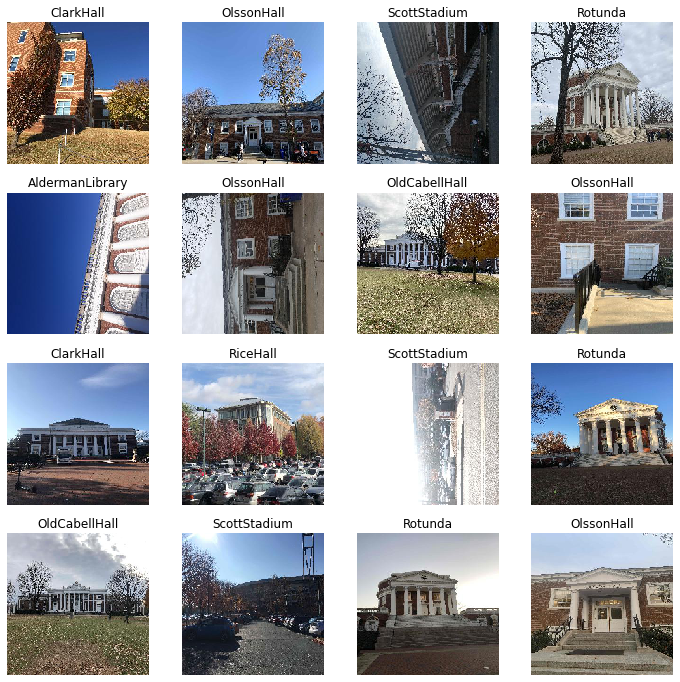

In [0]:
# Visualize some of the train samples
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks (recommended). 

Best of luck!

In [0]:
import tensorflow_hub as hub

# Transfer learning with the mobile net from tf
model = keras.models.Sequential([
  #keras.layers.Flatten(input_shape=[224,224,3]),
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                  trainable=False, input_shape=[224,224,3]),
  keras.layers.Dense(300, activation="relu", name="hidden_1"),
  keras.layers.Dense(100, activation="relu", name="hidden_2"),
  keras.layers.Dense(18, activation="softmax", name="output"),
])

In [0]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_1 (Dense)             (None, 300)               384300    
_________________________________________________________________
hidden_2 (Dense)             (None, 100)               30100     
_________________________________________________________________
output (Dense)               (None, 18)                1818      
Total params: 2,674,202
Trainable params: 416,218
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# compile the model and use gradient descent optimizer with sparse categorical crossentropy as the loss function
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [0]:
# fit the model
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=early_stop)

Epoch 1/30
313/313 [==============================] - 65s 206ms/step - loss: 1.8609 - accuracy: 0.4752 - val_loss: 1.3093 - val_accuracy: 0.6365
Epoch 2/30
313/313 [==============================] - 60s 192ms/step - loss: 1.0789 - accuracy: 0.7019 - val_loss: 1.0012 - val_accuracy: 0.7141
Epoch 3/30
313/313 [==============================] - 62s 198ms/step - loss: 0.8237 - accuracy: 0.7691 - val_loss: 0.7982 - val_accuracy: 0.7769
Epoch 4/30
313/313 [==============================] - 66s 212ms/step - loss: 0.6805 - accuracy: 0.8103 - val_loss: 0.7497 - val_accuracy: 0.7813
Epoch 5/30
313/313 [==============================] - 65s 209ms/step - loss: 0.5873 - accuracy: 0.8397 - val_loss: 0.7189 - val_accuracy: 0.7989
Epoch 6/30
313/313 [==============================] - 65s 207ms/step - loss: 0.5178 - accuracy: 0.8610 - val_loss: 0.6434 - val_accuracy: 0.8185
Epoch 7/30
313/313 [==============================] - 63s 201ms/step - loss: 0.4609 - accuracy: 0.8780 - val_loss: 0.5870 - val_ac

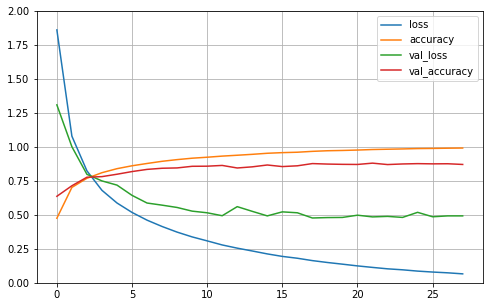

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# plot the training history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
# test the model on the test data
model.evaluate(X_test, y_test)

57/57 [==============================] - 8s 146ms/step - loss: 1.4086 - accuracy: 0.7028


[1.4086045026779175, 0.7027778029441833]

BAD

In [0]:
# transform the target datasets to a one hot encoded form and see if using categorical encoding with the adam optimizer performs better
y_train_cat = np_utils.to_categorical(y_train, 18)
y_test_cat = np_utils.to_categorical(y_test, 18)
y_val_cat = np_utils.to_categorical(y_val, 18)

In [0]:
# load the vgg19 CNN architecture - make sure to set include top equal to false to remove the softmax layer
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg19.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
vgg_features_val = vgg19.predict(X_val)

In [0]:
vgg_features_test = vgg19.predict(X_test)

In [0]:
# extract the features that vgg recognizes from ImageNet
vgg_features_train = vgg19.predict(X_train)

In [0]:
# look at the input shape
vgg_features_train.shape

(10003, 7, 7, 512)

In [0]:
model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,512)))
model2.add(Dense(300, activation='relu'))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(18, activation='softmax'))

In [0]:
# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               7526700   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               4

In [0]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# train model using features generated from VGG16 model
history2 = model2.fit(vgg_features_train, y_train_cat, epochs=100, batch_size=128, validation_data=(vgg_features_val, y_val_cat), callbacks=early_stop)

Epoch 1/100
79/79 [==============================] - 2s 22ms/step - loss: 2.2972 - accuracy: 0.3339 - val_loss: 1.4925 - val_accuracy: 0.5682
Epoch 2/100
79/79 [==============================] - 2s 19ms/step - loss: 1.3888 - accuracy: 0.6057 - val_loss: 1.4825 - val_accuracy: 0.5282
Epoch 3/100
79/79 [==============================] - 2s 20ms/step - loss: 1.0771 - accuracy: 0.6956 - val_loss: 1.0446 - val_accuracy: 0.7093
Epoch 4/100
79/79 [==============================] - 2s 19ms/step - loss: 0.8960 - accuracy: 0.7490 - val_loss: 1.0480 - val_accuracy: 0.7033
Epoch 5/100
79/79 [==============================] - 2s 19ms/step - loss: 0.8288 - accuracy: 0.7633 - val_loss: 0.9579 - val_accuracy: 0.7401
Epoch 6/100
79/79 [==============================] - 2s 19ms/step - loss: 0.7427 - accuracy: 0.7881 - val_loss: 0.8965 - val_accuracy: 0.7441
Epoch 7/100
79/79 [==============================] - 2s 19ms/step - loss: 0.7594 - accuracy: 0.7782 - val_loss: 0.9472 - val_accuracy: 0.7365
Epoch 

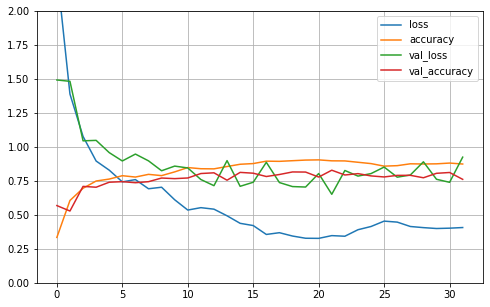

In [0]:
import pandas as pd
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
model2.evaluate(vgg_features_test, y_test_cat)

57/57 [==============================] - 0s 4ms/step - loss: 2.1009 - accuracy: 0.5011


[2.100935935974121, 0.5011110901832581]

WORSE

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_____________________________

In [0]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val],
                    epochs=10, batch_size=32)

Epoch 1/10
313/313 [==============================] - 116s 370ms/step - loss: 0.8285 - accuracy: 0.7750 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
313/313 [==============================] - 115s 367ms/step - loss: 0.1268 - accuracy: 0.9725 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
313/313 [==============================] - 115s 366ms/step - loss: 0.0417 - accuracy: 0.9911 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
313/313 [==============================] - 115s 366ms/step - loss: 0.0222 - accuracy: 0.9959 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
313/313 [==============================] - 115s 366ms/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
313/313 [==============================] - 115s 366ms/step - loss: 0.0093 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
313/313 [==============================] - 115s 366ms/step - loss

In [0]:
model.evaluate(X_test, y_test, verbose=0)

[0.7173983454704285, 0.8438888788223267]

A LITTLE BETTER

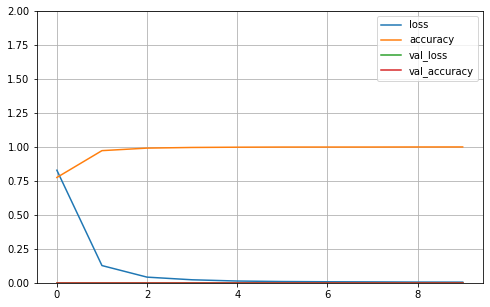

In [0]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
from tensorflow.keras.applications import vgg16, vgg19, inception_v3, xception, resnet50, inception_resnet_v2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

sparse=tf.keras.losses.sparse_categorical_crossentropy
cat=tf.keras.losses.categorical_crossentropy

In [0]:
# vgg16
def vgg16_fine_tune(x_train, y_train, x_val, y_val, loss, n_classes):
    vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    x = vgg16_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=predictions)
    for layer in vgg16_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss=loss)
    model.fit(x_train, y_train)

    for i, layer in enumerate(model.layers):

        if i < 15:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=loss, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=256, epochs=50, shuffle=True, validation_data=(x_val, y_val))
    return history

In [0]:
# vgg19
def vgg19_fine_tune(x_train, y_train, x_val, y_val, loss, n_classes):
    vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
    x = vgg19_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=vgg19_model.input, outputs=predictions)
    for layer in vgg19_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss=loss)
    model.fit(x_train, y_train)

    for i, layer in enumerate(model.layers):

        if i < 17:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=loss, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=256, epochs=50, shuffle=True, validation_data=(x_val, y_val))
    return history

In [0]:
# inception_v3
def inception_fine_tune(x_train, y_train, x_val, y_val, loss, n_classes):
    inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
    x = inception_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inception_model.input, outputs=predictions)
    for layer in inception_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss=loss)
    model.fit(x_train, y_train)

    for i, layer in enumerate(model.layers):

        if i < 249:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=loss, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=256, epochs=50, shuffle=True, validation_data=(x_val, y_val))
    return history

In [0]:
# xception
def xception_fine_tune(x_train, y_train, x_val, y_val, loss, n_classes):
    xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
    x = xception_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=xception_model.input, outputs=predictions)
    for layer in xception_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss=loss)
    model.fit(x_train, y_train)

    for i, layer in enumerate(model.layers):

        if i < 115:
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss=loss, metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=256, epochs=50, shuffle=True, validation_data=(x_val, y_val))
    return history

In [0]:
hist_vgg16 = vgg16_fine_tune(X_train, y_train_hot_encoded, X_val, y_val_hot_encoded, cat, n_classes)

313/313 [==============================] - 25s 81ms/step - loss: 2.2797
Epoch 1/50
40/40 [==============================] - 31s 779ms/step - loss: 1.7637 - accuracy: 0.4803 - val_loss: 1.6915 - val_accuracy: 0.5114
Epoch 2/50
40/40 [==============================] - 31s 773ms/step - loss: 1.6355 - accuracy: 0.5179 - val_loss: 1.5950 - val_accuracy: 0.5302
Epoch 3/50
40/40 [==============================] - 31s 773ms/step - loss: 1.5630 - accuracy: 0.5466 - val_loss: 1.5242 - val_accuracy: 0.5566
Epoch 4/50
40/40 [==============================] - 31s 772ms/step - loss: 1.5043 - accuracy: 0.5602 - val_loss: 1.4707 - val_accuracy: 0.5714
Epoch 5/50
40/40 [==============================] - 31s 772ms/step - loss: 1.4370 - accuracy: 0.5886 - val_loss: 1.4213 - val_accuracy: 0.5882
Epoch 6/50
40/40 [==============================] - 31s 773ms/step - loss: 1.4069 - accuracy: 0.5975 - val_loss: 1.3778 - val_accuracy: 0.6062
Epoch 7/50
40/40 [==============================] - 31s 774ms/step - l

In [0]:
hist_vgg16.model.evaluate(X_test, y_test_hot_encoded, verbose=1)

57/57 [==============================] - 5s 83ms/step - loss: 1.3106 - accuracy: 0.6528


[1.3105831146240234, 0.6527777910232544]

In [0]:
hist_vgg19 = vgg19_fine_tune(X_train, y_train_hot_encoded, X_val, y_val_hot_encoded, cat, n_classes)

313/313 [==============================] - 29s 94ms/step - loss: 2.2987
Epoch 1/50
40/40 [==============================] - 36s 910ms/step - loss: 1.8028 - accuracy: 0.4758 - val_loss: 1.7064 - val_accuracy: 0.5094
Epoch 2/50
40/40 [==============================] - 36s 905ms/step - loss: 1.6655 - accuracy: 0.5151 - val_loss: 1.5973 - val_accuracy: 0.5430
Epoch 3/50
40/40 [==============================] - 36s 905ms/step - loss: 1.5699 - accuracy: 0.5410 - val_loss: 1.5184 - val_accuracy: 0.5714
Epoch 4/50
40/40 [==============================] - 36s 906ms/step - loss: 1.4957 - accuracy: 0.5664 - val_loss: 1.4542 - val_accuracy: 0.6030
Epoch 5/50
40/40 [==============================] - 36s 905ms/step - loss: 1.4260 - accuracy: 0.5891 - val_loss: 1.3924 - val_accuracy: 0.6174
Epoch 6/50
40/40 [==============================] - 36s 903ms/step - loss: 1.3822 - accuracy: 0.6052 - val_loss: 1.3382 - val_accuracy: 0.6413
Epoch 7/50
40/40 [==============================] - 36s 903ms/step - l

In [0]:
hist_vgg19.model.evaluate(X_test, y_test_hot_encoded, verbose=1)

57/57 [==============================] - 5s 91ms/step - loss: 1.2679 - accuracy: 0.6756


[1.2678799629211426, 0.6755555272102356]

In [0]:
hist_inception = inception_fine_tune(X_train, y_train_hot_encoded, X_val, y_val_hot_encoded, cat, n_classes)

313/313 [==============================] - 16s 51ms/step - loss: 1.7111
Epoch 1/50
40/40 [==============================] - 19s 471ms/step - loss: 1.7273 - accuracy: 0.4949 - val_loss: 1.1488 - val_accuracy: 0.6825
Epoch 2/50
40/40 [==============================] - 16s 398ms/step - loss: 1.5793 - accuracy: 0.5791 - val_loss: 1.1765 - val_accuracy: 0.6917
Epoch 3/50
40/40 [==============================] - 16s 393ms/step - loss: 1.4611 - accuracy: 0.6289 - val_loss: 1.2008 - val_accuracy: 0.6901
Epoch 4/50
40/40 [==============================] - 16s 392ms/step - loss: 1.3864 - accuracy: 0.6429 - val_loss: 1.2122 - val_accuracy: 0.6909
Epoch 5/50
40/40 [==============================] - 16s 393ms/step - loss: 1.3250 - accuracy: 0.6605 - val_loss: 1.2131 - val_accuracy: 0.6941
Epoch 6/50
40/40 [==============================] - 16s 393ms/step - loss: 1.2718 - accuracy: 0.6765 - val_loss: 1.2054 - val_accuracy: 0.6937
Epoch 7/50
40/40 [==============================] - 16s 393ms/step - l

In [0]:
hist_inception.model.evaluate(X_test, y_test_hot_encoded, verbose=1)

57/57 [==============================] - 3s 53ms/step - loss: 1.3327 - accuracy: 0.6439


[1.3326501846313477, 0.6438888907432556]

In [0]:
hist_xception = xception_fine_tune(X_train, y_train_hot_encoded, X_val, y_val_hot_encoded, cat, n_classes)

313/313 [==============================] - 25s 80ms/step - loss: 1.4903
Epoch 1/50
40/40 [==============================] - 33s 817ms/step - loss: 1.6562 - accuracy: 0.5558 - val_loss: 1.2722 - val_accuracy: 0.6309
Epoch 2/50
40/40 [==============================] - 31s 763ms/step - loss: 1.5657 - accuracy: 0.5851 - val_loss: 1.4645 - val_accuracy: 0.5794
Epoch 3/50
40/40 [==============================] - 31s 764ms/step - loss: 1.4774 - accuracy: 0.6153 - val_loss: 1.4708 - val_accuracy: 0.5782
Epoch 4/50
40/40 [==============================] - 31s 764ms/step - loss: 1.4224 - accuracy: 0.6387 - val_loss: 1.3859 - val_accuracy: 0.6006
Epoch 5/50
40/40 [==============================] - 31s 764ms/step - loss: 1.3651 - accuracy: 0.6589 - val_loss: 1.2877 - val_accuracy: 0.6246
Epoch 6/50
40/40 [==============================] - 31s 764ms/step - loss: 1.3166 - accuracy: 0.6726 - val_loss: 1.2122 - val_accuracy: 0.6493
Epoch 7/50
40/40 [==============================] - 31s 764ms/step - l

In [0]:
hist_xception.model.evaluate(X_test, y_test_hot_encoded, verbose=1)

57/57 [==============================] - 5s 80ms/step - loss: 1.4701 - accuracy: 0.5828


[1.470145344734192, 0.5827777981758118]

In [0]:
hist_xception_sparse = xception_fine_tune(X_train, y_train, X_val, y_val, sparse, n_classes)

313/313 [==============================] - 25s 79ms/step - loss: 1.4872
Epoch 1/50
40/40 [==============================] - 31s 784ms/step - loss: 1.7083 - accuracy: 0.5246 - val_loss: 1.2654 - val_accuracy: 0.6261
Epoch 2/50
40/40 [==============================] - 31s 763ms/step - loss: 1.6024 - accuracy: 0.5742 - val_loss: 1.3951 - val_accuracy: 0.5950
Epoch 3/50
40/40 [==============================] - 30s 762ms/step - loss: 1.4925 - accuracy: 0.6152 - val_loss: 1.3707 - val_accuracy: 0.6010
Epoch 4/50
40/40 [==============================] - 31s 763ms/step - loss: 1.4251 - accuracy: 0.6385 - val_loss: 1.2906 - val_accuracy: 0.6253
Epoch 5/50
40/40 [==============================] - 31s 763ms/step - loss: 1.3653 - accuracy: 0.6595 - val_loss: 1.2095 - val_accuracy: 0.6521
Epoch 6/50
40/40 [==============================] - 31s 763ms/step - loss: 1.3206 - accuracy: 0.6727 - val_loss: 1.1506 - val_accuracy: 0.6725
Epoch 7/50
40/40 [==============================] - 31s 763ms/step - l

In [0]:
hist_xception_sparse.model.evaluate(X_test, y_test, verbose=1)

57/57 [==============================] - 4s 76ms/step - loss: 1.4402 - accuracy: 0.5956


[1.4402368068695068, 0.5955555438995361]